# Imports

In [157]:
#!pip install numpy-stl

In [158]:
#!pip install -U scikit-learn


In [159]:
#!pip install vtkplotlib

In [160]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [161]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [162]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [163]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [164]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [165]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[27.65682847 27.66395101 27.65689748 ...  8.68864353 24.9324861
  8.69011241]
[23.72569864 23.73180879 23.72575784 ...  7.45364344 21.38859314
  7.45490353]
[1.         1.         1.         ... 0.99873996 1.         0.99874137]
(5999,)


### Multinomial Sampling

In [166]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [167]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.0, -6.9390492, 84.58801), (75.01686, 0.66553295, 3.7812707), (81.66343, -8.798424, -2.1997812), (75.10282, -5.5423326, 83.16192), (87.13615, 6.7292814, 89.08131), (81.3266, -8.447791, 81.53156), (87.893486, 6.7292814, 87.769554), (80.082375, -7.9794145, 3.5336442), (88.926414, -7.138877, 3.0701475), (75.0, -8.610001, 88.18124), (75.0, -7.8332825, 94.00995), (75.0, -8.722893, 88.83761), (76.29851, -8.78582, -4.398447), (87.739876, 7.138877, 86.872154), (76.7258, -8.78582, -4.3192525), (75.08191, -5.0095077, 82.762886), (75.0, -4.7321377, 97.41936), (89.11159, -1.6554987, -6.452666), (75.23533, 7.6759295, -0.69033855), (82.8813, 6.7292814, 93.33614), (78.92292, 7.328478, 3.5944085), (80.18583, 6.7292814, 94.70956), (75.0, 0.99710757, 98.743324), (82.79202, -8.760632, -1.8612355), (77.26372, 6.7292814, 95.49254), (75.91289, 1.6554987, 98.61897), (75.003944, 0.66553295, 3.7751074), (79.815735, -8.760632, -4.541097), (84.55478, -0.99710757, 95.91307), (75.00652, 0.66553295, 3.775656), 

# KNN

In [168]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.0, -6.9390492, 84.58801], [75.01686, 0.66553295, 3.7812707], [81.66343, -8.798424, -2.1997812], [75.10282, -5.5423326, 83.16192], [87.13615, 6.7292814, 89.08131], [81.3266, -8.447791, 81.53156], [87.893486, 6.7292814, 87.769554], [80.082375, -7.9794145, 3.5336442], [88.926414, -7.138877, 3.0701475], [75.0, -8.610001, 88.18124], [75.0, -7.8332825, 94.00995], [75.0, -8.722893, 88.83761], [76.29851, -8.78582, -4.398447], [87.739876, 7.138877, 86.872154], [76.7258, -8.78582, -4.3192525], [75.08191, -5.0095077, 82.762886], [75.0, -4.7321377, 97.41936], [89.11159, -1.6554987, -6.452666], [75.23533, 7.6759295, -0.69033855], [82.8813, 6.7292814, 93.33614], [78.92292, 7.328478, 3.5944085], [80.18583, 6.7292814, 94.70956], [75.0, 0.99710757, 98.743324], [82.79202, -8.760632, -1.8612355], [77.26372, 6.7292814, 95.49254], [75.91289, 1.6554987, 98.61897], [75.003944, 0.66553295, 3.7751074], [79.815735, -8.760632, -4.541097], [84.55478, -0.99710757, 95.91307], [75.00652, 0.66553295, 3.775656], 

In [169]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [170]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  24


Number of nodes: 50
Number of edges: 620


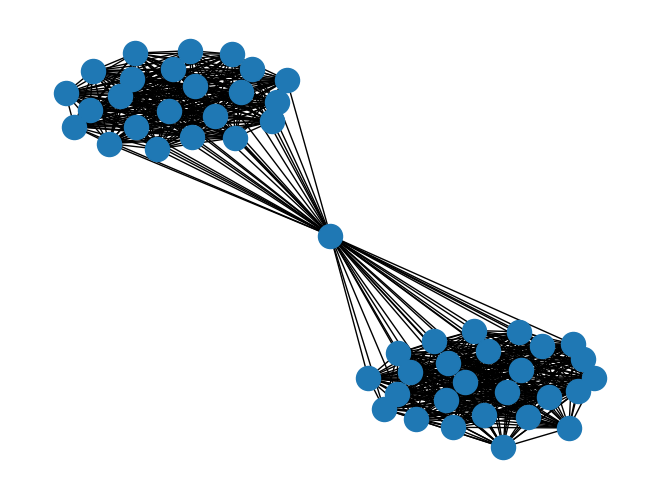

In [171]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [172]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [173]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\debor\AppData\Local\Temp\ipykernel_27876\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh

# Fonctions Loss

Récupération des points de l'espace de départ P

In [174]:
keys_input = list(graph._node.keys())
print(keys_input)
len(keys_input)  #return 5999

[(75.0252, -0.66553295, 3.8), (75.01418, -0.49935842, 16.7), (75.0, 0.0, 3.8), (75.00158, 0.16653232, 16.7), (75.0252, 0.66553295, 3.8), (75.03937, 0.8314692, 16.7), (75.10067, 1.3272538, 3.8), (75.12734, 1.4916434, 16.7), (75.22596, 1.9813722, 3.8), (75.26499, 2.1432736, 16.7), (75.40037, 2.6241417, 3.8), (75.45153, 2.7826276, 16.7), (75.62288, 3.2518802, 3.8), (75.68588, 3.4060426, 16.7), (75.892235, 3.8609922, 3.8), (75.96672, 4.0099483, 16.7), (76.20689, 4.4479885, 3.8), (76.29242, 4.590885, 16.7), (76.565025, 5.0095077, 3.8), (76.661125, 5.145526, 16.7), (76.96461, 5.5423326, 3.8), (77.07072, 5.670694, 16.7), (77.40334, 6.0434117, 3.8), (77.51886, 6.1633806, 16.7), (77.87872, 6.5098743, 3.8), (78.002975, 6.620764, 16.7), (78.388016, 6.9390492, 3.8), (78.5203, 7.0402236, 16.7), (78.92831, 7.328478, 3.8), (79.06786, 7.4193583, 16.7), (79.4965, 7.6759295, 3.8), (79.64253, 7.755995, 16.7), (80.08935, 7.9794145, 3.8), (80.24101, 8.048206, 16.7), (80.703445, 8.237194, 3.8), (80.859886, 

5999

Récupération des points de l'espace de départ Ps

In [175]:
keys_output = list(extended_graph)
print(keys_output)
len(keys_output)  #return: 50

[(75.0, -6.9390492, 84.58801), (75.10282, -5.5423326, 83.16192), (75.891914, -5.5423326, 82.95048), (75.08191, -5.0095077, 82.762886), (75.0, -8.610001, 88.18124), (75.44612, -3.8609922, 81.9727), (76.96192, -5.5423326, 81.30282), (75.0, -8.722893, 88.83761), (81.3266, -8.447791, 81.53156), (75.0, -7.8332825, 94.00995), (75.0, 6.0434117, 83.60335), (75.0, -4.7321377, 97.41936), (84.017044, -4.1574683, 95.08502), (83.721436, -1.6554987, 96.30598), (84.55478, -0.99710757, 95.91307), (75.0, 0.99710757, 98.743324), (75.91289, 1.6554987, 98.61897), (77.26372, 6.7292814, 95.49254), (79.62394, 6.2811418, 95.43102), (80.18583, 6.7292814, 94.70956), (82.8813, 6.7292814, 93.33614), (87.13615, 6.7292814, 89.08131), (87.893486, 6.7292814, 87.769554), (87.739876, 7.138877, 86.872154), (75.01686, 0.66553295, 3.7812707), (75.00652, 0.66553295, 3.775656), (75.003944, 0.66553295, 3.7751074), (76.20689, -4.4479885, 3.8), (78.92292, 7.328478, 3.5944085), (75.23533, 7.6759295, -0.69033855), (75.53198, -7.

50

Création de la liste normes entre chaque point

In [180]:
import numpy as np

def compare_and_norm(keys_x, keys_y):
    normes_carre = []

    for x in keys_x:
        # Convertir les tuples en arrays NumPy pour le calcul de la norme
        keys_x_np = np.array(x)
        # Calculer la norme euclidienne au carré pour chaque point y dans keys_y
        distances_carre = [np.linalg.norm(keys_x_np - np.array(y))**2 for y in keys_y]
        # Ajouter la distance minimale au carré à la liste
        norme_carre = min(distances_carre)
        normes_carre.append(norme_carre)

    return normes_carre

def min_pour_y_list(keys_x, keys_y):
    # Calculer le min pour chaque point y dans keys_y
    return min(compare_and_norm(keys_x, keys_y))

def min_pour_x_list(keys_x, keys_y):
    # Calculer le min pour chaque point x dans keys_x
    return min(compare_and_norm(keys_x, keys_y))


In [181]:
compare_and_norm(keys_input, keys_output)

[1.772156609391061,
 168.25056947063786,
 0.4435691908329318,
 167.1428124765598,
 0.00042032104887823607,
 166.9216212744359,
 0.4452492592381283,
 167.58825156238254,
 1.7755060040690864,
 169.13885869650494,
 3.983576501364098,
 171.56461294856945,
 7.056800247271951,
 174.85155129432678,
 10.977591234878673,
 178.98091906958962,
 15.716326002744609,
 183.9290154874916,
 10.979558271401459,
 181.63755552890598,
 7.067572577643887,
 177.93547841153577,
 4.002776627621699,
 175.08540424121838,
 1.8027270989256436,
 173.1037020581507,
 0.480045326089229,
 172.00174312185936,
 0.04229685096270064,
 171.7858334006096,
 0.4919820857494983,
 172.45716290170185,
 1.8265397761357605,
 174.011940824279,
 4.0383030814709855,
 176.44125572551275,
 7.114616402048398,
 179.7311189352913,
 11.037884536772765,
 183.8628005339424,
 15.78559139151281,
 188.81256977853718,
 21.3305796357929,
 194.55205010319423,
 27.64100721926502,
 201.04839234263636,
 34.68086505350243,
 208.26437871891903,
 42.4096

Chamfer distance

In [182]:
def d_P_Ps(P, Ps, p):
    """
    Parameters:
    - P : the input vertex set, a list of tuples
    - Ps : the sampled points, a list of tuples
    - p : their respective probabilities, a number

    Returns:
        d_P_Ps_result (float) : a float, the Chamfer distance
    """
    sum_part1 = sum(p * min_pour_y_list([x], Ps) for x in P)
    sum_part2 = sum(p * min_pour_x_list(Ps, [y]) for y in Ps)

    d_P_Ps_result = float(sum_part1 + sum_part2)

    return d_P_Ps_result

In [183]:
print("Chamfer distance d_P_Ps : ", d_P_Ps(keys_input, keys_output, 0.2))


Chamfer distance d_P_Ps :  61012.9470799999
